In [2]:
# Instalación de librerías necesarias
#!pip install pandas numpy scikit-learn matplotlib seaborn fastapi uvicorn

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Carga del dataset
url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"
data = pd.read_csv(url)

# Vista inicial de los datos
data.head()

# Información sobre las columnas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984045 entries, 0 to 984044
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           984045 non-null  int64  
 1   Date Rptd       984045 non-null  object 
 2   DATE OCC        984045 non-null  object 
 3   TIME OCC        984045 non-null  int64  
 4   AREA            984045 non-null  int64  
 5   AREA NAME       984045 non-null  object 
 6   Rpt Dist No     984045 non-null  int64  
 7   Part 1-2        984045 non-null  int64  
 8   Crm Cd          984045 non-null  int64  
 9   Crm Cd Desc     984045 non-null  object 
 10  Mocodes         837566 non-null  object 
 11  Vict Age        984045 non-null  int64  
 12  Vict Sex        844481 non-null  object 
 13  Vict Descent    844471 non-null  object 
 14  Premis Cd       984031 non-null  float64
 15  Premis Desc     983489 non-null  object 
 16  Weapon Used Cd  324280 non-null  float64
 17  Weapon Des

In [3]:
# Selección de columnas relevantes
columns_to_keep = ['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Vict Age', 'Vict Sex']
data = data[columns_to_keep]

# Renombrar columnas para facilitar el uso
data.columns = ['Date', 'Time', 'Area', 'Crime Type', 'Victim Age', 'Victim Sex']

# Manejo de valores nulos
data = data.dropna()

# Conversión de datos de fecha y tiempo
data['Time'] = data['Time'].apply(lambda x: int(str(x).zfill(4)[:2]))  # Extraer la hora del tiempo

# Codificación de variables categóricas
label_encoders = {}
for col in ['Area', 'Crime Type', 'Victim Sex']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Dividir los datos en características (X) y etiquetas (y)
X = data[['Time', 'Area', 'Victim Age', 'Victim Sex']]
y = data['Crime Type']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest con parámetros ajustados
model = RandomForestClassifier(
    n_estimators=50,       # Reduce el número de árboles
    max_depth=10,          # Limita la profundidad máxima de los árboles
    random_state=42,
    n_jobs=-1              # Usa todos los núcleos disponibles para paralelizar
)

# Entrenar el modelo
model.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(model, "crime_model_rf.pkl")

# Evaluación inicial
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       516
           1       0.24      0.04      0.07       204
           2       0.17      0.20      0.18     10389
           3       0.00      0.00      0.00       942
           4       0.14      0.33      0.19     14854
           5       0.50      0.02      0.03        57
           6       0.10      0.00      0.01       500
           7       0.00      0.00      0.00       869
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00      1627
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        86
          14       1.00      0.00      0.00      2847
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        74
          17       0.00      0.00      0.00      1189
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

# Cargar el modelo
model = joblib.load("crime_model_rf.pkl")

# Inicializar FastAPI
app = FastAPI()

# Definir el esquema de entrada
class CrimeData(BaseModel):
    time: int
    area: int
    victim_age: int
    victim_sex: int

@app.post("/predict")
def predict(data: CrimeData):
    # Convertir datos de entrada en un formato para el modelo
    features = [[data.time, data.area, data.victim_age, data.victim_sex]]
    prediction = model.predict(features)
    return {"predicted_crime_type": int(prediction[0])}

In [7]:
!uvicorn app:app --reload --port 8000

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [15385] using StatReload
ERROR:    Error loading ASGI app. Could not import module "app".
INFO:     Stopping reloader process [15385]
^C


<ipython-input-10-a881d2ff34ef>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


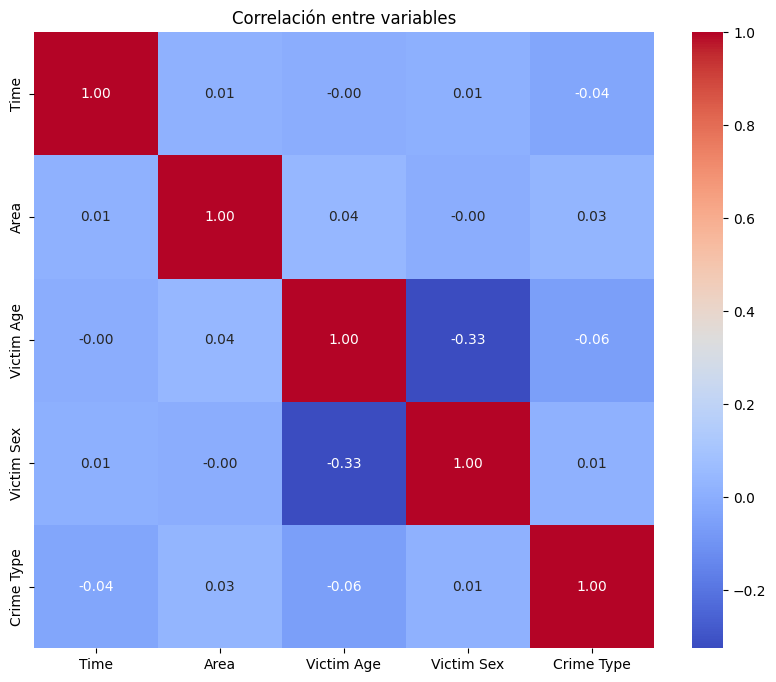

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data manipulation

# ... (Your existing code for data loading and preprocessing) ...

# Convert 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Extract relevant numerical features for correlation analysis
numerical_data = data[['Time', 'Area', 'Victim Age', 'Victim Sex', 'Crime Type']]

# Mapa de calor de correlación
corr_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables")
plt.show()

In [11]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.day_name()

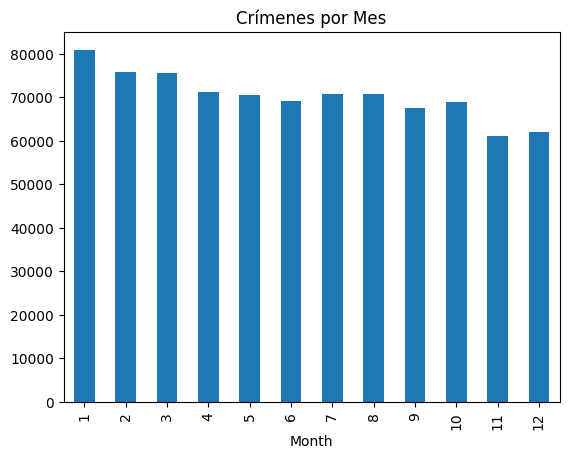

In [12]:
monthly_crimes = data.groupby('Month').size()
monthly_crimes.plot(kind='bar', title='Crímenes por Mes')
plt.show()

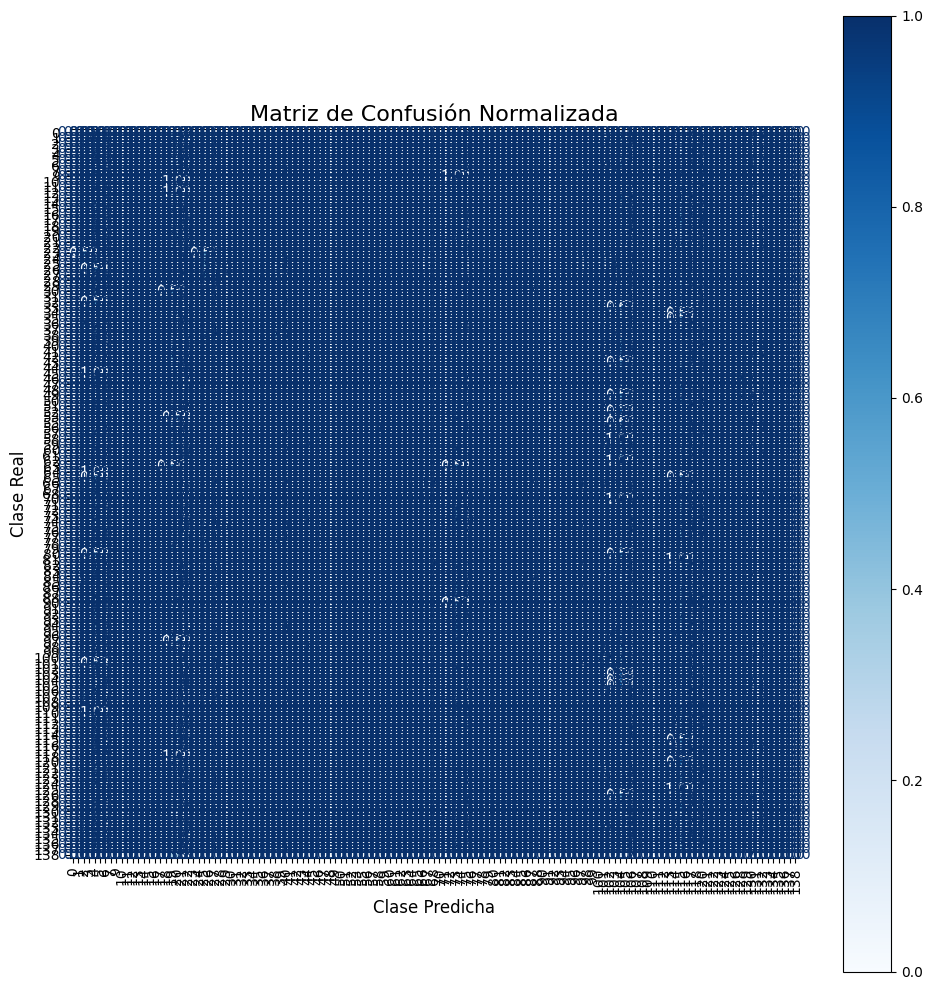

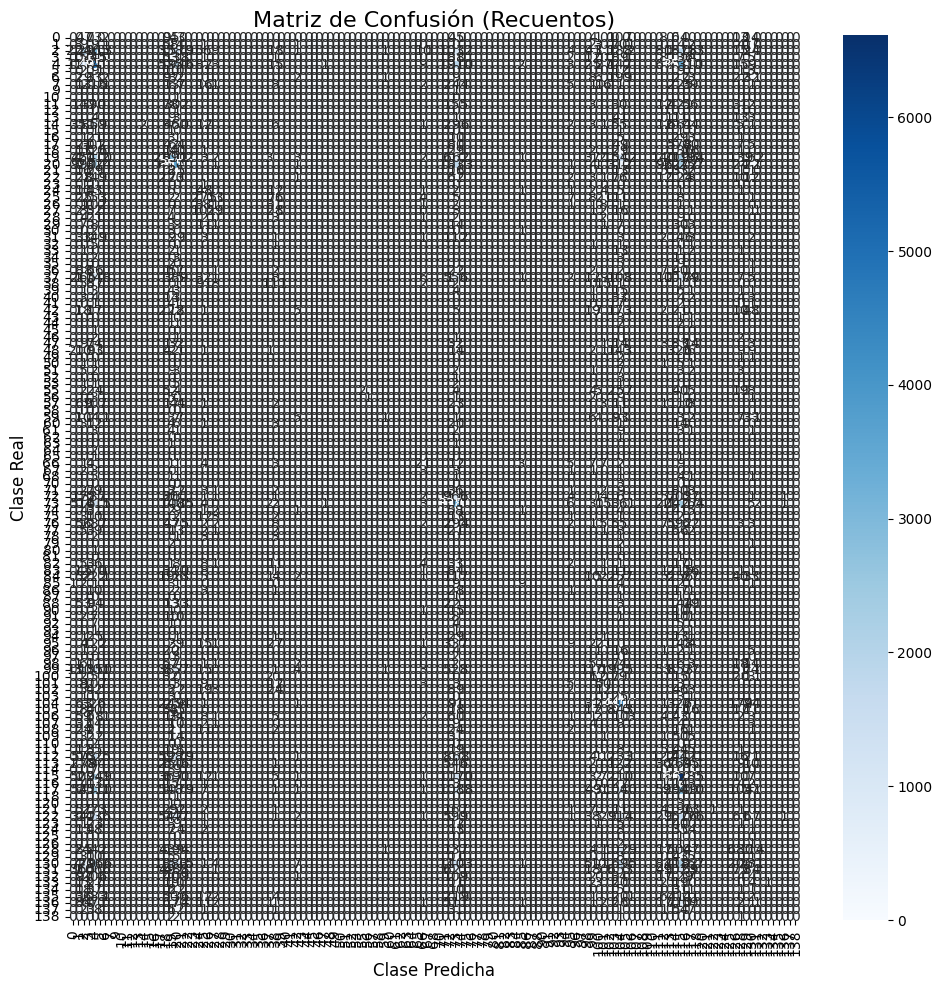

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique class labels from predictions and actual values
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter model.classes_ to include only the present labels
display_labels = [label for label in model.classes_ if label in unique_labels]

# Generate confusion matrix using only the unique labels
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Normalize the confusion matrix for better interpretation
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

# Create ConfusionMatrixDisplay with filtered labels and normalized matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=display_labels)

# Plot the confusion matrix with improved readability
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size
disp.plot(ax=ax, cmap="Blues", include_values=True, xticks_rotation='vertical', values_format=".2f")
ax.set_title("Matriz de Confusión Normalizada", fontsize=16)  # Add title
ax.set_xlabel("Clase Predicha", fontsize=12)  # Add x-axis label
ax.set_ylabel("Clase Real", fontsize=12)  # Add y-axis label
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Optionally, display raw counts in a heatmap for comparison
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=display_labels, yticklabels=display_labels)
plt.title("Matriz de Confusión (Recuentos)", fontsize=16)
plt.xlabel("Clase Predicha", fontsize=12)
plt.ylabel("Clase Real", fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

Varianza explicada por cada componente: [0.8319901  0.08734542]


In [29]:
y_prob = model.predict_proba(X_test)
print("Probabilidades de predicción:", y_prob[:5])

Probabilidades de predicción: [[6.03897966e-03 4.26410787e-03 6.52526969e-03 6.69286518e-03
  3.31000687e-03 5.75100225e-04 1.21865062e-02 1.38397453e-04
  2.99478982e-05 2.23413502e-05 0.00000000e+00 9.56179108e-04
  0.00000000e+00 3.22417177e-03 1.61327015e-03 0.00000000e+00
  2.92254880e-04 2.40659069e-03 2.05723445e-03 1.22881884e-01
  1.67199217e-02 4.03945852e-04 7.43306940e-03 3.72882084e-05
  7.48786117e-05 8.06953006e-05 1.82449828e-04 1.85155720e-04
  3.91701852e-05 4.13389644e-04 7.77687209e-05 1.88414276e-04
  0.00000000e+00 6.02790643e-04 1.30185865e-04 3.67814279e-04
  2.41878516e-05 4.21983223e-03 1.87374063e-05 9.08043138e-04
  2.52749253e-03 4.18545750e-04 1.64596726e-02 1.73642750e-04
  2.48525713e-04 1.09415886e-05 2.29923570e-05 8.92897171e-04
  6.53924547e-03 2.54694967e-04 2.32582288e-04 9.14257829e-04
  1.45827990e-05 1.71658781e-05 0.00000000e+00 1.94493011e-02
  5.51970703e-04 5.91068496e-04 1.97952228e-05 1.07198786e-02
  2.37925291e-06 1.35227798e-03 0.000000

In [33]:
import numpy as np
y_pred = np.argmax(y_prob, axis=1)
print("Clases predichas:", y_pred[:5])

Clases predichas: [104 104   4 115  20]


In [34]:
confidences = np.max(y_prob, axis=1)
print("Confianza de predicciones:", confidences[:5])

Confianza de predicciones: [0.20086056 0.20747817 0.13545833 0.13436987 0.1486393 ]


In [35]:
threshold = 0.7
y_pred_thresholded = [np.argmax(row) if max(row) >= threshold else -1 for row in y_prob]
print("Clases con umbral:", y_pred_thresholded[:5])

Clases con umbral: [-1, -1, -1, -1, -1]


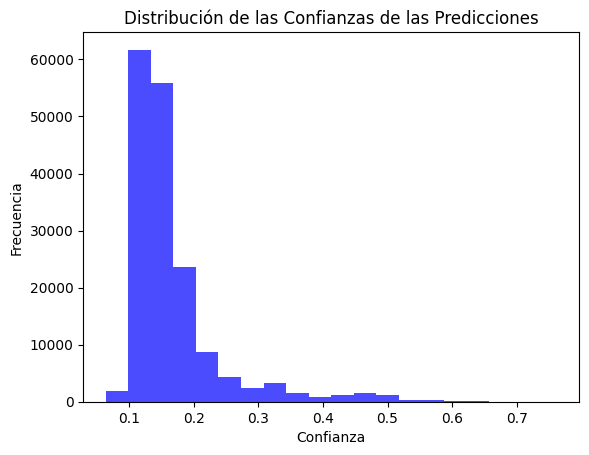

In [36]:
import matplotlib.pyplot as plt

confidences = np.max(y_prob, axis=1)
plt.hist(confidences, bins=20, color='blue', alpha=0.7)
plt.title('Distribución de las Confianzas de las Predicciones')
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')
plt.show()


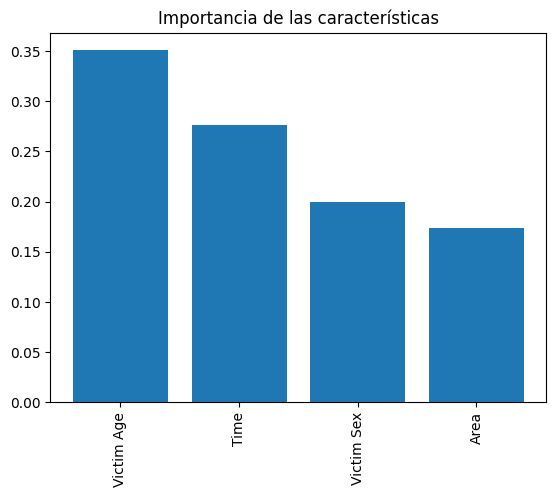

In [30]:
importances = model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Importancia de las características")
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpykn15c7n/satbf5aa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpykn15c7n/7o3wca4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29817', 'data', 'file=/tmp/tmpykn15c7n/satbf5aa.json', 'init=/tmp/tmpykn15c7n/7o3wca4_.json', 'output', 'file=/tmp/tmpykn15c7n/prophet_modeldp12_qiw/prophet_model-20241118212630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


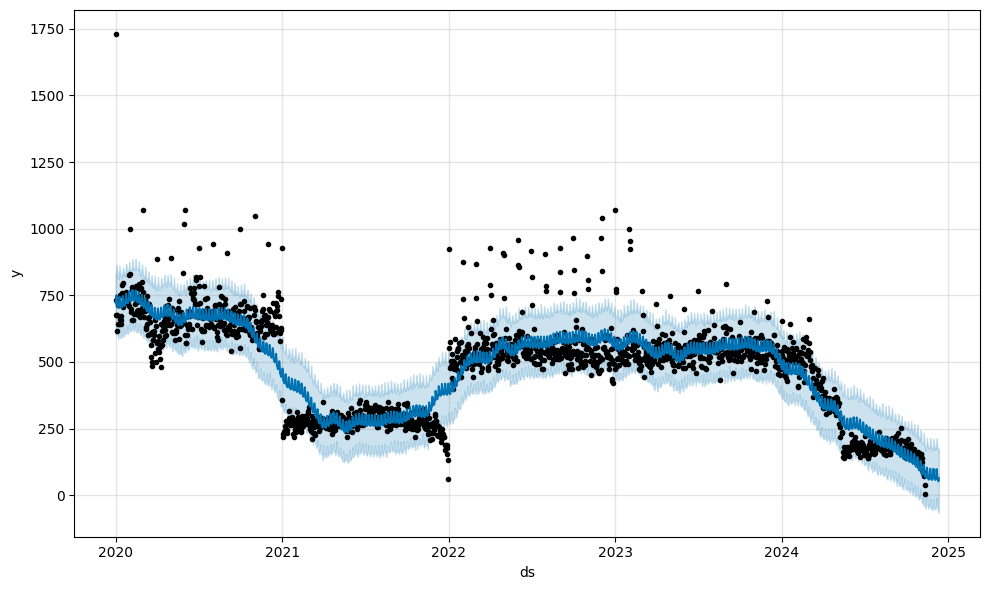

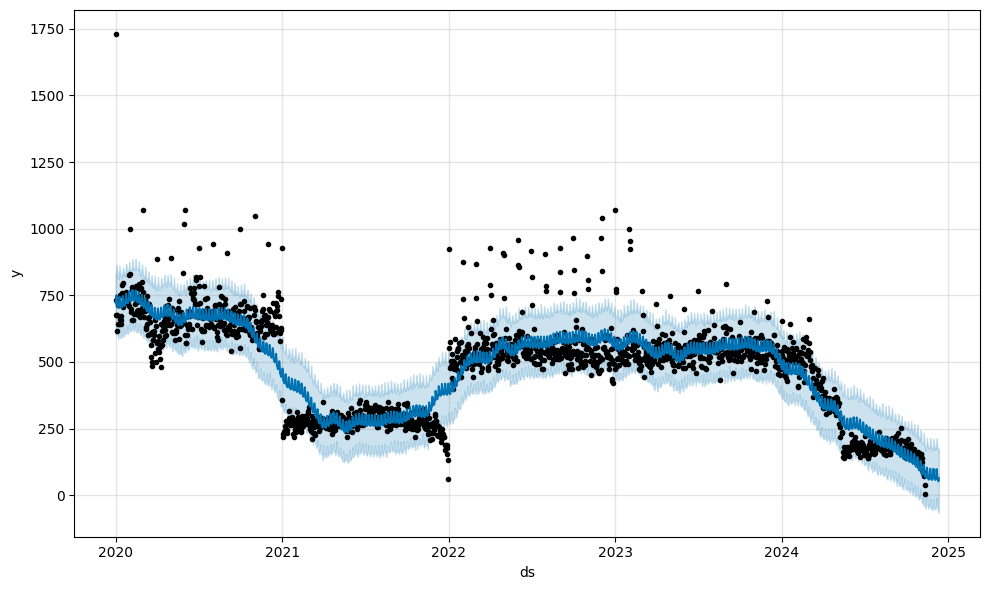

In [32]:
!pip install prophet
from prophet import Prophet

# Preparar datos para Prophet
df = data.groupby('Date').size().reset_index(name='Crimes')
df.columns = ['ds', 'y']

# Modelo Prophet
model = Prophet()
model.fit(df)
forecast = model.predict(model.make_future_dataframe(periods=30))
model.plot(forecast)


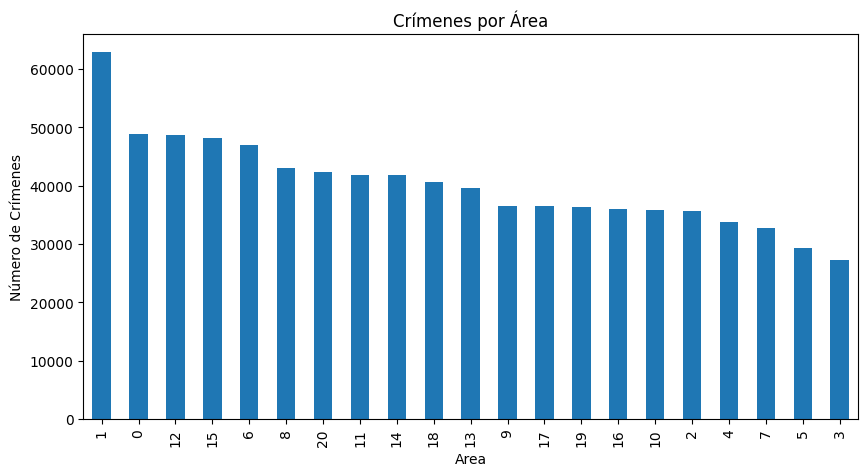

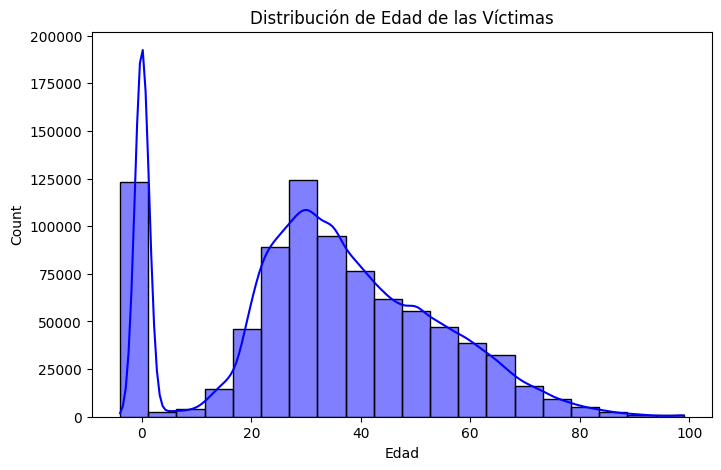

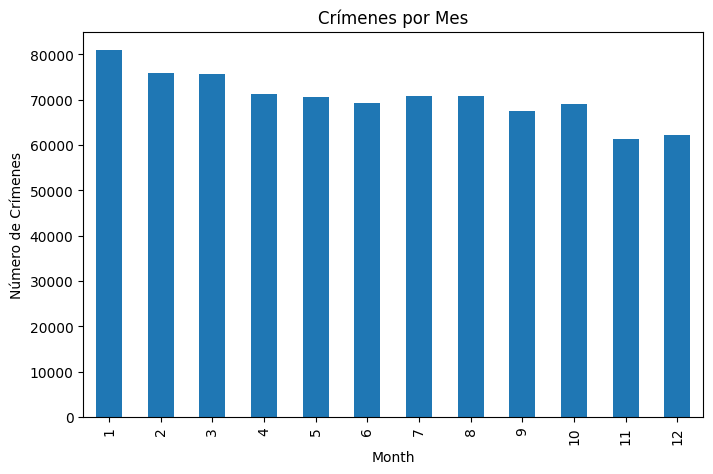

In [37]:
# Crímenes por área
area_counts = data['Area'].value_counts()
area_counts.plot(kind='bar', title='Crímenes por Área', figsize=(10, 5))
plt.ylabel('Número de Crímenes')
plt.show()

# Distribución de edades de las víctimas
plt.figure(figsize=(8, 5))
sns.histplot(data['Victim Age'], bins=20, kde=True, color='blue')
plt.title('Distribución de Edad de las Víctimas')
plt.xlabel('Edad')
plt.show()

# Tendencias mensuales de crímenes
data['Month'] = data['Date'].dt.month
monthly_crimes = data.groupby('Month').size()
monthly_crimes.plot(kind='bar', title='Crímenes por Mes', figsize=(8, 5))
plt.ylabel('Número de Crímenes')
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpykn15c7n/0rznlfnk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpykn15c7n/p3z8o42b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13057', 'data', 'file=/tmp/tmpykn15c7n/0rznlfnk.json', 'init=/tmp/tmpykn15c7n/p3z8o42b.json', 'output', 'file=/tmp/tmpykn15c7n/prophet_modelssa__xyz/prophet_model-20241118213900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


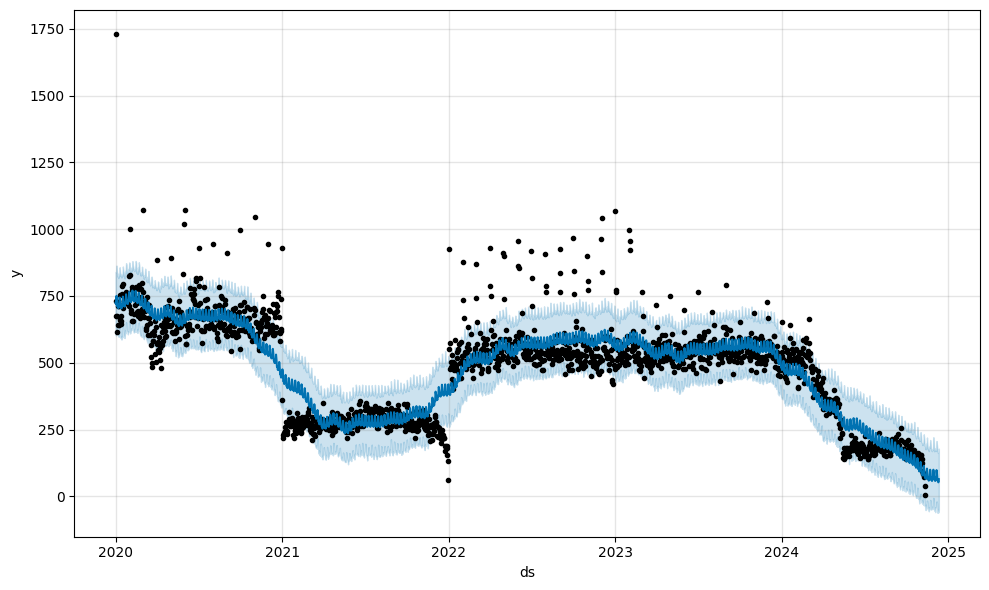

In [42]:
# Preparar datos para Prophet
trend_data = data.groupby('Date').size().reset_index(name='Crimes')
trend_data.columns = ['ds', 'y']

# Modelo Prophet
prophet_model = Prophet()
prophet_model.fit(trend_data)

# Predicción futura
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Visualización
fig = prophet_model.plot(forecast)
